# Parámetros globales del *Notebook*

In [1]:
# Para definir los path
import os

# Define si estamos ejecutando el Notebook en nuestro 
# ordenador ("local") o en Google Colab ("remote")
RUNNING_ENV = "remote"

# Path que vamos a usar como base para el resto de paths
BASE_PATH = "./" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Directorio en el que guardamos los scripts de python que usamos 
# como libreria propia
LIB_PATH = os.path.join(BASE_PATH, "lib")

# Directorio en el que guardamos los datos de entrenamiento y test
DATA_PATH = os.path.join(BASE_PATH, "data")

# Numero de procesos que queremos usar
NUM_WORKERS = 2

# Batch size que queremos usar para entrenamiento offline
DATALOADER_BACH_SIZE = 32

# Bath size que queremos usar para entrenamiento online
ONLINE_BATCH_SIZE = 2**10

# Tamaño del conjunto de triples aleatorios
# Tiene que ser un multiplo de DATALOADER_BACH_SIZE para que
# la red tome correctamente los batches que espera
RANDOM_TRIPLETS_DATA_SIZE = DATALOADER_BACH_SIZE * 15

# Numero de epocas por las que queremos entrenar
TRAINING_EPOCHS = 10

# Numero de epocas que usamos en k-fold Cross Validation para 
# hacer la exploracion de los parametros
HYPERPARAMETER_TUNING_EPOCHS = 7

# Numero de folds que usamos en k-fold Cross Validation para el hyperparameter tuning
NUMBER_OF_FOLDS = 4

# Margen para la funcion de perdida
MARGIN = 0.1

# Dimension del embedding que calculamos
EMBEDDING_DIMENSION = 2

# Numero de vecinos a usar en la adaptacion a clasificador
NUMBER_NEIGHBOURS = 3

# Semilla aleatoria para aquellas partes en las que fijamos el estado aleatorio
RANDOM_SEED = 123456789

# Controla si queremos evitar toda la parte del entrenamiento
# con triples aleatorios
# TODO -- antes de entregar poner a False
SKIP_RANDOM_TRIPLETS_TRAINING = True

# Controla si queremos entrenar el modelo y usarlo o 
# no entrenar nada y cargar el modelo entrenado de disco
# Cuando es False, entrenamos y ademas actualizamos el modelo 
# en disco
# TODO -- poner esto a False
USE_CACHED_MODEL = True
MODEL_CACHE_FOLDER = os.path.join(BASE_PATH, "cached_models")

# Controla si queremos saltarnos o no el hyperparameter 
# tuning para el entrenamiento online 
SKIP_HYPERPARAMTER_TUNING = False

# Autorización si estamos usando Google Drive

In [2]:
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importando los módulos que vamos a usar

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
import torchvision.datasets as datasets

# Para poder usar ResNet18 preentrenado
import torchvision.models as models 
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from pprint import pprint
import gc
import functools
import math

# Todas las piezas concretas que usamos de sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, silhouette_score
from sklearn.model_selection import ShuffleSplit

# Cargamos en el Notebook todos los ficheros .py que definen nuestra propia libreria
# Usamos esta libreria para escribir el codigo base necesario para llevar a cabo ciertas
# tareas del notebook (como el bucle de entrenamiento) que no tienen interes mostrar
# en este notebook
!cp -r "$LIB_PATH"/* .

# Ahora que hemos cargado estos ficheros en el Notebook, importamos lo necesario
# de nuestra propia libreria
import core
import time
import copy
import board
import filesystem
import metrics
from train_loggers import ClassificationLogger, SilentLogger, TripletLoggerOffline, TripletLoggerOnline, TrainLogger
from models.resnet import *
from visualizations import *
from custom_loss import triplet_loss_batch_hard
from tqdm.notebook import tqdm
from core import train_model_offline, train_model_online

from sklearn.neighbors import KNeighborsClassifier

# Funciones comunes que vamos a usar en el notebook

In [4]:
def show_learning_curve(training_history: dict):
    # Tomamos las dos funciones de perdida
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    
    # Mostramos las graficas
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
def try_to_clean_memory(): 
    torch.cuda.empty_cache() 
    gc.collect()

# Carga del conjunto de datos

- Cargamos los datos de entrenamiento y test
- Además, separamos train en train y validación

In [5]:
# Transformaciones que queremos aplicar al cargar los datos
# Ahora solo pasamos las imagenes a tensores, pero podriamos hacer aqui normalizaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO -- aqui podemos añadir la normaliazcion de datos
])

# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Separamos train en train y validacion
train_dataset, validation_dataset = core.split_train_test(train_dataset, 0.8)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

test_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size = DATALOADER_BACH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

# Definiendo las clases con las que vamos a trabajar

In [6]:
# Clases con las que vamos a trabajar
# Esta lista especifica la relacion numero -> nombre de la forma
# classes[numero] = nombre
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

# Análisis Exploratorio de datos

Mostramos algunas imágenes con sus clases para asegurar que hemos cargado correctamente las imágenes del conjunto de datos:

La clase obtenida es: Pullover


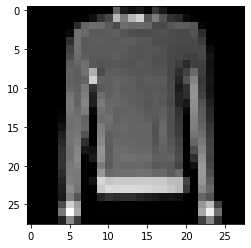

La clase obtenida es: Sandal


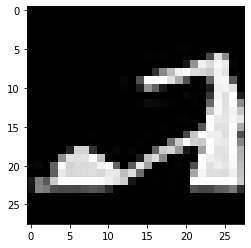

La clase obtenida es: Sandal


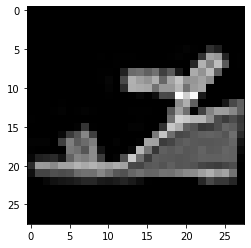

La clase obtenida es: Dress


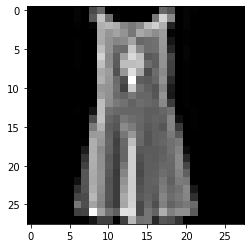

La clase obtenida es: Bag


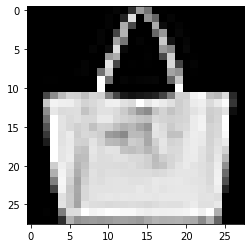

In [7]:
imgs_to_show = 5

for _ in range(imgs_to_show):

    # Cargamos un batch de imagenes
    images, images_classes = next(iter(train_loader))

    # Nos quedamos con la primera imagen del batch
    img, img_class = images[0], images_classes[0]

    # Mostramos alguna informacion de la imagen
    print(f"La clase obtenida es: {classes[img_class]}")

    # Re-escalamos y mostramos la imagen
    img = img.reshape((28, 28))
    show_img(img, color_format_range = (-1.0, 1.0))

Mostramos ahora unas cuantas imágenes de forma simultánea:

Mostramos ahora los tamaños del dataset:

In [8]:
print(f"Tenemos {len(train_dataset)} imágenes de entrenamiento")
print(f"Tenemos {len(test_dataset)} imágenes de test")

Tenemos 48000 imágenes de entrenamiento
Tenemos 10000 imágenes de test


# Definiendo el modelo base

- A continuación, definimos el modelo que vamos a usasr como base para nuestra red siamesa
- Usaremos el modelo pre-entrenado ResNet18, pre-entrenado en ImageNet

In [9]:
class ResNet18(torch.nn.Module):
    def __init__(self, embedding_dimension: int):
        
        super(ResNet18, self).__init__()

        # Dimension del embedding que la red va a calcular
        self.embedding_dimension = embedding_dimension
        
        # Tomamos el modelo pre-entrenado ResNet18
        self.pretrained = models.resnet18(pretrained=True)
        
        # Cambiamos la primera convolucion para que en vez
        # de tres canales acepte un canal para las imagenes
        # de entrada
        self.pretrained.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Cambiamos la ultima capa fc Linear(in_features=512, out_features=1000, bias=True)
        # para calcular un embedding de dimension mucho menor, especificada por parameatro
        # TODO -- comentar en la memoria el cambio de ERROR que hacer esto nos ha supuesto
        self.pretrained.fc = nn.Linear(in_features=512, out_features=self.embedding_dimension, bias=True)
        
        # Por defecto siempre realizamos la permutacion del tensor de entrada
        self.should_permute = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Tenemos como entrada tensores (1, DATALOADER_BACH_SIZE, 28, 28) y 
        # queremos tensores (DATALOADER_BACH_SIZE, 1, 28, 28) para poder trabajar
        # con la red pre-entrenada
        # Usamos permute en vez de reshape porque queremos que tambien funcione al
        # realizar inferencia con distintos tamaños de minibatch (ie. 1)
        if self.should_permute is True:
            x = torch.permute(x, (1, 0, 2, 3))

        # Usamos directamente la red pre-entrenada para hacer el forward
        x = self.pretrained.forward(x)
        
        return x
    
    def set_permute(self, should_permute: bool):
        self.should_permute = should_permute

# Generación de triples

- Para entrenar la red siamesa, necesitamos dar triples con los que computar el *triplet loss*
- Por ello, es necesaria una fase previa de *triplets mining*
- En todos los casos, crearemos *Datasets* de *Pytorch* para representar la creación de los triples
- Hacemos esto basándonos el la [documentación oficial de Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

## Generación de triples aleatorios

- Es la forma más sencilla y directa para generar triples
- Usaremos esta generación como baseline para más tarde realizar comparaciones

In [10]:
from torch.utils.data import RandomSampler

class RandomTriplets(Dataset):
    """
    Dataset en el que los elementos son triples obtenidos de forma aleatoria
    """

    def __init__(self, base_data: Dataset, custom_len: int, transform = None):
        self.base_data = base_data
        self.custom_len = custom_len
        self.transform = transform
        self.random_sampler = RandomSampler(self.base_data, replacement=True, num_samples=1, generator=None)
        
        # Por motivos de eficiencia, pre-computamos una lista de listas, de forma
        # que tengamos disponibles las listas con las posiciones de cada clase por
        # separado.
        self.posiciones_clases = self.__precompute_list_of_classes()

    def __len__(self):
        """
        Devolvemos el tamaño del dataset
        Como estamos generando triples aleatorios, devolvemos el tamaño definido
        por parametro
        """
        return self.custom_len

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Funcion que es llamada cuando se hace dataset[idx]
        En vez de devolver una imagen (que es lo comun en esta clase dataset), 
        devolvemos un triple (anchor, positive, negative) aleatorio
        """

        # Hacemos esto por temas de eficiencia
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Tomamos una imagen aleatoria que sera el ancla
        anchor, anchor_class = self.base_data[next(iter(self.random_sampler))]

        # Tomamos una imagen de la misma clase, que sera la positiva, de forma aleatoria
        random_index = np.random.choice(self.posiciones_clases[anchor_class])
        positive, positive_class = self.base_data[random_index]

        # Tomamos una imagen de otra clase, que sera la negativa
        # Empiezo tomando una clase que no sea la del anchor
        posible_classes = list(range(10))
        posible_classes.remove(anchor_class)
        negative_class = np.random.choice(posible_classes)

        # Ahora tomamos un indice aleatorio de esta clase negativa
        random_index = np.random.choice(self.posiciones_clases[negative_class])
        negative, negative_class = self.base_data[random_index]
        
        # Generamos ahora el triple
        triplet = [anchor, positive, negative]

        # Aplicamos la transformacion dada al dataset al ejemplo que devolvemos
        if self.transform:
            triplet = [self.transform(np.array(img)) for img in triplet]

        return triplet

    def __precompute_list_of_classes(self) -> List[List[int]]:
        """
        Calcula la lista con las listas de posiciones de cada clase por separado
        """
        # Inicializamos la lista de listas
        posiciones_clases = [[] for _ in range(10)]

        # Recorremos el dataset y colocamos los indices donde corresponde
        for idx, element in enumerate(self.base_data):
            _, img_class = element
            posiciones_clases[img_class].append(idx)

        return posiciones_clases

    
class CustomReshape(object):
    """Pasamos la imagen de (28, 1, 28) a (28, 28)"""

    def __call__(self, image):
        image = image.reshape(28, 28)
        return image

In [11]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False:
   
    # Antes de modificar la base de datos para convertirla a triples
    # la guardamos, porque mas adelante nos hara falta
    old_train_dataset = train_dataset
    old_test_dataset = test_dataset

    # Necesitamos hacer reshape de las imagenes para que
    # sean (28, 28) y no (28, 1, 28)
    transform = transforms.Compose([
        transforms.ToTensor(),

        # Hacemos reshape de las imagenes para
        # que sean tensores (28, 28)
        CustomReshape(),
    ])

    # Generamos los triples aleatorios para training
    random_triplets_train = RandomTriplets(
        base_data = train_dataset,
        custom_len = RANDOM_TRIPLETS_DATA_SIZE,
        transform = transform,
    )

    train_loader = torch.utils.data.DataLoader(
        random_triplets_train,
        batch_size = DATALOADER_BACH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )

    # Generamos los triples aleatorios para validacion
    random_triplets_validation = RandomTriplets(
        base_data = validation_dataset,
        custom_len = RANDOM_TRIPLETS_DATA_SIZE,
        transform = transform,
    )

    validation_loader = torch.utils.data.DataLoader(
        random_triplets_validation,
        batch_size = DATALOADER_BACH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )

    # Generamos los triples aleatorios para test
    random_triplets_test = RandomTriplets(
        base_data = test_dataset,
        custom_len = RANDOM_TRIPLETS_DATA_SIZE,
        transform = transform,
    )

    test_loader = torch.utils.data.DataLoader(
        random_triplets_test,
        batch_size = DATALOADER_BACH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )

    # Visualizamos algunos triples aleatorios para comprobar el funcionamiento
    custom_triplet = random_triplets_train[2]
    for i in custom_triplet :
        show_img(i, color_format_range = (-1.0, 1.0))


# Definición de la función de pérdida

In [12]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:       
       
        distance_positive = self.euclidean_distance(anchor, positive)
        distance_negative = self.euclidean_distance(anchor, negative)

        # Usamos Relu para que el error sea cero cuando la resta de las distancias
        # este por debajo del margen. Si esta por encima del margen, devolvemos la
        # identidad de dicho error. Es decir, aplicamos Relu a la formula que 
        # tenemos debajo
        loss = torch.relu(distance_positive - distance_negative + self.margin)

        return loss
    
    def euclidean_distance(self, first: torch.Tensor, second: torch.Tensor) -> float:
        return ((first - second) * (first - second)).sum()
    
class TripletLossCustom(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLossCustom, self).__init__()
        self.margin = margin
        self.base_loss = TripletLoss(self.margin)
    
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        losses = torch.tensor(
            [self.base_loss(current[0], current[1], current[2]) for current in batch], 
            requires_grad=True
        )
        return losses.mean()

# Entrenamiento del modelo

In [13]:
net = ResNet18(EMBEDDING_DIMENSION)

# TODO -- fijar bien los parametros
parameters = dict()
parameters["epochs"] = TRAINING_EPOCHS
parameters["lr"] = 0.001
parameters["criterion"] = TripletLossCustom(MARGIN)

# Definimos el logger que queremos para el entrenamiento
logger = TripletLoggerOffline(
    net = net,
    iterations = 10 * DATALOADER_BACH_SIZE,
    loss_func = parameters["criterion"],
)

print(net)

ResNet18(
  (pretrained): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False:

    training_history = train_model_offline(
        net = net,
        path = os.path.join(BASE_PATH, "tmp"),
        parameters = parameters,
        train_loader = train_loader,
        validation_loader = validation_loader,
        name = "SiameseNetwork",
        logger = logger,
        snapshot_iterations = None
    )

In [15]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False: show_learning_curve(training_history)

In [16]:
# A partir de este punto ya no volvemos a entrenar el modelo
# Asi que lo ponemos en modo evaluacion para que no lleve 
# la cuenta de los gradientes
net.eval()

ResNet18(
  (pretrained): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Evaluación del modelo

- Mostramos algunas métricas fundamentales sobre el conjunto de

In [17]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False: core.test_model(net, test_loader, parameters["criterion"])

# Adaptación del modelo para usarlo como clasificador

- Nuestro modelo genera un *embedding*
- Adaptamos el modelo para que, a partir de dicho embedding, podamos usarlo como un clasificador

In [18]:
class EmbeddingToClassifier:
    """
    Clase que toma un modelo que calcula embeddings y lo convierte
    a un modelo que sirve para una tarea de clasificacion
    
    Usamos K-NN para el modelo de clasificacion
    """
    
    def __init__(self, embedder: nn.Module, k: int, data_loader):
        
        # El modelo que calcula los embeddings
        self.embedder = embedder
         
        # Dataloader que representa el dataset que usamos para k-nn
        self.data_loader = data_loader
        
        # Tomamos el dispositivo en el que esta el modelo y los
        # datos, porque nos va a hacer falta durante todo el codigo
        self.device = core.get_device()
        
        # Calculamos todos los embeddings de los puntos
        self.dataset_embedded = self.__calculate_embedding()
        
        # Modelo de clasificacion k-nn
        self.k = k
        self.knn = self.__fit_knn()
                
    def predict_proba(self, img, batch_mode: bool = False) -> int:
        
        # Ponemos la red en modo evaluacion
        self.embedder.eval()
        
        # Tenemos una unica imagen, lo que queremos es
        # tener un batch de una imagen para que la red
        # pueda trabajar con ello
        single_img_batch = torch.Tensor(img)
        
        # Calculamos el embedding de la imagen
        img_embedding = None
        if batch_mode is False:
            img_embedding = self.embedder(single_img_batch[None, ...].to(self.device)) 
        else:
            img_embedding = self.embedder(single_img_batch.to(self.device)) 
        
        # Pasamos el embedding a cpu que es donde esta 
        # el modelo knn de scikit learn
        img_embedding = img_embedding.cpu().detach().numpy() 
        
        # Antes de salir de la funcion volvemos a poner
        # a la red en modo entrenamiento
        self.embedder.train()
        
        # Usamos dicho embedding para clasificar con knn
        return self.knn.predict(img_embedding)
    
    def predict(self, img, batch_mode: bool = False) -> int:
        
        # Ponemos la red en modo evaluacion
        self.embedder.eval()
        
        # Tenemos una unica imagen, lo que queremos es
        # tener un batch de una imagen para que la red
        # pueda trabajar con ello
        single_img_batch = torch.Tensor(img)
        
        # Calculamos el embedding de la imagen
        img_embedding = None
        if batch_mode is False:
            img_embedding = self.embedder(single_img_batch[None, ...].to(self.device)) 
        else:
            img_embedding = self.embedder(single_img_batch.to(self.device)) 
        
        # Pasamos el embedding a cpu que es donde esta 
        # el modelo knn de scikit learn
        img_embedding = img_embedding.cpu().detach().numpy() 
        
        # Antes de salir de la funcion volvemos a poner
        # a la red en modo entrenamiento
        self.embedder.train()
        
        # Usamos dicho embedding para clasificar con knn
        return self.knn.predict(img_embedding)

                    
    def predict_using_embedding(self, embedding: np.ndarray) -> int:
        """
        Realizamos la prediccion, pero en vez de usando la imagen
        pasamos directamente el embedding de la imagen (en ocasiones
        podemos mejorar el rendimiento pre-computando el embedding de
        todo un conjunto de imagenes)
        """
        
        # Usamos dicho embedding para clasificar con knn
        return self.knn.predict(embedding)
    
    def predict_proba_using_embedding(self, embedding: np.ndarray) -> int:
        """
        Realizamos la prediccion, pero en vez de usando la imagen
        pasamos directamente el embedding de la imagen (en ocasiones
        podemos mejorar el rendimiento pre-computando el embedding de
        todo un conjunto de imagenes)
        """
        
        # Usamos dicho embedding para clasificar con knn
        return self.knn.predict_proba(embedding)
        
    def __calculate_embedding(self):
        """Dado el conjunto de imagenes con sus etiquetas, calculamos
        el conjunto de embedding con sus etiquetas"""
        
        embedded_imgs = []
        labels = []

        # Por motivos que desconocemos, ahora los tensores vienen
        # en el formato que espera la red, asi que no tenemos que
        # realizar la permutacion del tensor
        self.embedder.set_permute(False)
        
        for img, img_class in self.data_loader:
            
            # TODO -- esto hay que borrarlo
            if np.random.rand() < 0.01:
                break
            
            # Calculamos el embedding de la imagen
            img_embedding = self.embedder(img.to(self.device))
            
            # Añadimos el embedding asociado a la etiqueta
            embedded_imgs.append(img_embedding)
            labels.append(img_class)
        
        # Antes de devolver los datos, volvemos a colocar la opcion
        # de que permute los tensores
        self.embedder.set_permute(True)

        return embedded_imgs, labels

    def __fit_knn(self):
        
        # Tomamos los datos en el formato que espera sklearn
        # para realizar el fit
        x, y = self.prepare_data_for_sklearn()
        
        knn = KNeighborsClassifier(n_neighbors = self.k)
        knn.fit(x, y)
        return knn

    def scatter_plot(self):
        """
        Hacemos un scatter plot del embedding obtenido
        """
        
        # Solo hacemos este plot cuando la dimension del 
        # embedding es 2
        if EMBEDDING_DIMENSION != 2:
            return
        
        # Tomamos los datos en el formato adecuado para hacer el plot
        x, y = self.prepare_data_for_sklearn()
        
        # Los ejes x,y son los datos de nuestro vector x
        # El color de los puntos lo dan las etiquetas almacenadas en y
        plt.scatter(x = x[:, 0], y = x[:, 1], c = y)
        plt.show()
        
    def prepare_data_for_sklearn(self): 
        """
        Tomamos las imagenes y las etiquetas, y las devolvemos en un
        formato adecuado para sklearn y matplotlib. Esto es:
            - Pasar los datos a memoria RAM
            - Aplanar los datos (tenemos los datos agrupados en minibatches)
        """

        # Separamos los datos segun espera sklearn
        x = self.dataset_embedded[0]
        y = self.dataset_embedded[1]

        # Pasamos de una lista de sublistas (por los minibatches)
        # a una lista. Tomamos la idea de:
        # https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
        x = [item for sublist in x for item in sublist]
        y = [item for sublist in y for item in sublist]

        # Forzamos a usar la memoria RAM (podrian estar los datos
        # en memoria GPU) 
        x = np.array([element.cpu().detach().numpy() for element in x])
        y = np.array([element.cpu().detach().numpy() for element in y])

        return x, y

Para la adaptación al clasificador, necesitamos tomar las imágenes junto a sus clases. Antes teníamos conjuntos de triples sin clases, ahora recuperamos la información original necesaria para la adaptación

In [19]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False:

    # Cargamos el dataset usando torchvision, que ya tiene el conjunto
    # preparado para descargar
    train_dataset = old_train_dataset
    test_dataset = old_test_dataset

    # Data loaders para acceder a los datos
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = DATALOADER_BACH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = DATALOADER_BACH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS,
        pin_memory = True,
    )


    classifier = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = train_loader)

Evaluamos este clasificador en un conjunto pequeño de imágenes de test. Más adelante tomamos métricas de dicho clasificador:

In [20]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False:

    # Hacemos esto y no `in test_dataset[:max_iterations]`
    # para no tener que tomar todo el dataset y quedarnos con
    # una parte de el, que es un proceso mucho mas lento que usar
    # el iterador que da `in test_dataset` y parar con el contador
    counter = 0
    max_iterations = 20

    for img, img_class in test_dataset:
        predicted_class = classifier.predict(img)
        print(f"Etiqueta verdadera: {img_class}, etiqueta predicha: {predicted_class[0]}")

        # Actualizamos el contador
        counter += 1
        if counter == max_iterations: break

# Plot del embedding

- Aprovechamos el cálculo realizado en la clase que realiza la adaptación a clasificación para mostrar gráficamente el embedding calculado
- Esta gráfica solo la visualizamos cuando el embedding tiene dimensión 2

In [21]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False: classifier.scatter_plot()

## Evaluación del clasificador obtenido

- Ahora que hemos adaptado el modelo para usarlo como clasificador, podemos consultar ciertas métricas de clasificación

In [22]:
def calculate_roc_auc(true_labels_prob: np.array, predicted_labels_prob: np.array) -> float:
    """
    Calcula el area bajo la curva ROC, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    
    Las listas de etiquetas deben ser etiquetas probabilisticas
    """
    return roc_auc_score(true_labels_prob, predicted_labels_prob, multi_class = "ovo")
    
def calculate_accuracy(true_labels: np.array, predicted_labels: np.array) -> float:
    """
    Calcula el accuracy, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    """
    return accuracy_score(true_labels, predicted_labels)

def calculate_silhouette(x, y):
    """Calcula el indice de silhouette para el embedding calculado por el modelo"""
    return silhouette_score(x, y)

def evaluate_model(model, train_loader, test_loader) -> dict:
    """
    Evalua, usando distintas metricas, el modelo que hemos entrenado
    Tambien evaluamos el embedding obtenido, no solo el clasificador
    
    Devuelve un diccionario con todas las metricas calculadas con el modelo
    """
    
    # Diccionario en el que vamos a almacenar todas las metricas
    metrics = dict()
    
    # Tomamos los arrays en formato adecuado para calcular ciertas metricas
    x_train, y_train = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = train_loader).prepare_data_for_sklearn()
    x_test, y_test = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = test_loader).prepare_data_for_sklearn()
    
    # Empezamos usando el modelo para realizar las predicciones+
    # Usamos predicciones probabilisticas pues estas son fundamentales para
    # la metrica roc auc
    train_predicted_labels_prob = model.predict_proba_using_embedding(x_train)
    test_predicted_labels_prob = model.predict_proba_using_embedding(x_test)

    # Tomamos ahora las etiqeutas sin probabilidad
    train_predicted_labels= model.predict_using_embedding(x_train)
    test_predicted_labels = model.predict_using_embedding(x_test)
    
    # Tomamos las metricas de accuracy
    metrics["train_acc"] = calculate_accuracy(y_train, train_predicted_labels)
    metrics["test_acc"] = calculate_accuracy(y_test, test_predicted_labels)
    
    # Tomamos las areas bajo la curva ROC
    metrics["train_roc_auc"] = calculate_roc_auc(y_train, train_predicted_labels_prob)
    metrics["test_roc_auc"] = calculate_roc_auc(y_test, test_predicted_labels_prob)
    
    # Tomamos el indice de silhouette
    metrics["train_silhouette"] = calculate_silhouette(x_train, y_train)
    metrics["test_silhouette"] = calculate_silhouette(x_test, y_test)

    # Devolvemos las metricas en formato diccionario, que nos va a ser comodo para
    # pasarlas a tablas y para mostrar muchas metricas simultaneamente
    return metrics

In [23]:
# Controlamos si queremos ejecutar esta seccion o no 
if SKIP_RANDOM_TRIPLETS_TRAINING is False:

    classifier.embedder.set_permute(False)

    metrics = evaluate_model(classifier, train_loader, test_loader)
    pprint(metrics)

    classifier.embedder.set_permute(True)

# Definición de la función de pérdida online

- Comenzamos el trabajo para adaptar el entrenamiento al uso de triples difíciles dentro de un minibatch, de forma online

In [24]:
# Copiamos esto de https://stackoverflow.com/a/22279947
# Lo necesitamos para saltarnos el elemento de una lista de
# forma eficiente
import itertools as it
def skip_i(iterable, i):
    itr = iter(iterable)
    return it.chain(it.islice(itr, 0, i), it.islice(itr, 1, None))


class OnlineTripletLoss(nn.Module):
    
    def __init__(self, margin=1.0):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.base_loss = TripletLoss(self.margin)
        
        # Pre-computamos una lista de listas en la que accedemos a los 
        # elementos de la forma list[label][posicion]
        # Con esto nos evitamos tener que realizar la separacion en positivos
        # y negativos repetitivamente
        # 
        # Notar que el pre-computo debe realizarse por cada llamada a forward,
        # con el minibatch correspondiente. Por tanto, nos beneficia usar minibatches
        # grandes
        self.list_of_classes = None
        
        # Si queremos usar self.list_of_classes para calcular todos los 
        # negativos de una clase, necesitamos dos for que vamos a repetir
        # demasiadas veces
        self.list_of_negatives = None
        
    def forward(self, embeddings: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:        
        
        loss = 0
                
        # Pre-computamos la separacion en positivos y negativos
        self.list_of_classes = self.__precompute_list_of_classes(labels)
        
        # Pre-computamos la lista de negativos de cada clase
        self.list_of_negatives = self.__precompute_negative_class()
        
        # Iteramos sobre todas los embeddings de las imagenes del dataset
        for embedding, img_label in zip(embeddings, labels):

            # Calculamos las distancias a positivos y negativos
            # Nos aprovechamos de la pre-computacion
            positive_distances = [
                self.base_loss.euclidean_distance(embedding, embeddings[positive])
                for positive in self.list_of_classes[img_label]
            ]
            
            # Ahora nos aprovechamos del segundo pre-computo realizado
            negative_distances = [
                self.base_loss.euclidean_distance(embedding, embeddings[negative])
                for negative in self.list_of_negatives
            ]
            
            # Tenemos una lista de tensores de un unico elemento (el valor
            # de la distancia). Para poder usar argmax pasamos todo esto
            # a un unico tensor
            positive_distances = torch.tensor(positive_distances)
            negative_distances = torch.tensor(negative_distances)
                        
            # Calculamos la funcion de perdida
            positives = self.list_of_classes[img_label]
            negatives = self.list_of_negatives[img_label]
            
            worst_positive_idx = positives[torch.argmax(positive_distances)]
            worst_negative_idx = negatives[torch.argmin(negative_distances)]
            
            worst_positive = embeddings[worst_positive_idx]
            worst_negative = embeddings[worst_negative_idx]
            
            loss += self.base_loss(embedding, worst_positive, worst_negative)
        
        return loss
    
    def __precompute_list_of_classes(self, labels) -> List[List[int]]:
        """
        Calcula la lista con las listas de posiciones de cada clase por separado
        """
        
        # Inicializamos la lista de listas
        posiciones_clases = [[] for _ in range(10)]

        # Recorremos el dataset y colocamos los indices donde corresponde
        for idx, label in enumerate(labels):
            posiciones_clases[label].append(idx)

        return posiciones_clases
    
    def __precompute_negative_class(self):
        
        # Inicializamos la lista
        list_of_negatives = [None] * 10
        
        for label in range(10):
            list_of_negatives[label] = [
                idx
                for current_list in skip_i(self.list_of_classes, label)
                for idx in current_list
            ]
            
        return list_of_negatives

# Volvemos a cargar los datos

- Con esta función de pérdida ya no necesitamos calcular de forma offline los triples
- Así que volvemos a cargar el dataset original, sin el pre-cómputo de triples

In [25]:
# Transformaciones que queremos aplicar al cargar los datos
# Ahora solo pasamos las imagenes a tensores, pero podriamos hacer aqui normalizaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO -- aqui podemos añadir la normaliazcion de datos
])

# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Separamos train en train y validacion
train_dataset, validation_dataset = core.split_train_test(train_dataset, 0.8)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = ONLINE_BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size = ONLINE_BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)

test_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size = ONLINE_BATCH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

# Hyperparameter tuning

In [26]:
def custom_cross_validation(net, parameters, train_dataset, k):
    """Funcion propia para hacer k-fold cross validation de una red convolucional"""

    # Definimos la forma en la que vamos a hacer el split de los folds
    ss = ShuffleSplit(n_splits=k, test_size=0.25, random_state=RANDOM_SEED)
    
    # Lista en la que guardamos las perdidas encontradas en cada fold
    losses = []

    # Iteramos usando el split que nos da sklearn
    for train_index, validation_index in ss.split(train_dataset):
        
        # Tenemos los indices de los elementos, asi que tomamos los dos datasets
        # usando dichos indices
        train_fold = [train_dataset[idx] for idx in train_index]
        validation_fold = [train_dataset[idx] for idx in validation_index]

        # Transformamos los datasets en dataloaders
        train_loader = torch.utils.data.DataLoader(
            train_fold,
            batch_size = ONLINE_BATCH_SIZE,
            shuffle = True,
            num_workers = NUM_WORKERS,
            pin_memory = True,
        )
        validation_loader = torch.utils.data.DataLoader(
            validation_fold,
            batch_size = ONLINE_BATCH_SIZE,
            shuffle = True,
            num_workers = NUM_WORKERS,
            pin_memory = True,
        )

        # Entrenamos la red
        _ = train_model_online(
            net = net,
            path = os.path.join(BASE_PATH, "tmp"),
            parameters = parameters,
            train_loader = train_loader,
            validation_loader = validation_loader,
            name = "SiameseNetworkOnline",
            logger = SilentLogger(),
            snapshot_iterations = None
        )

        # Evaluamos la red en el fold de validacion
        net.eval()
        loss = metrics.calculate_mean_triplet_loss_online(net, validation_loader, parameters["criterion"], 1.0)
        loss = float(loss) # Pasamos el tensor de un unico elemento a un float simple

        # Añadimos el loss a nuestra lista
        losses.append(loss)
    
    # Devolvemos el array en formato numpy para que sea mas comodo trabajar con ella
    return np.array(losses)


In [ ]:
# Controlamos si queremos realizar el hyperparameater tuning o no
if SKIP_HYPERPARAMTER_TUNING is False:

    # Para controlar que parametros ya hemos explorado y queremos saltar
    already_explored_parameters = [
        # Embedding dimension, learning rate, margin
        (2, 0.0001, 0.01),
        (2, 0.0001, 1),
        (3, 0.0001),
    ]

    # Parametros que queremos mover
    #margin_values = [0.01, 0.1, 1.0]
    # TODO -- volver a poner todos los valores
    margin_values = [1.0]
    learning_rate_values = [0.0001, 0.001, 0.01]
    embedding_dimension_values = [2, 3, 4]
    
    # Parametros que fijamos de antemano
    epochs = HYPERPARAMETER_TUNING_EPOCHS
    
    # Llevamos la cuenta de los mejores parametros y el mejor error encontrados hasta
    # el momento
    best_loss = None
    best_parameters = {
        "embedding_dimension": None,
        "lr": None,
        "margin": None
    }
    
    # Exploramos las combinaciones de parametros
    for margin in margin_values:
        for learning_rate in learning_rate_values:
            for embedding_dimension in embedding_dimension_values:
        
                print(f"Optimizando para margin: {margin}, lr: {learning_rate}, embedding_dim: {embedding_dimension}")

                # Comprobamos si tenemos que saltarnos el calculo de algun valor
                # porque ya se haya hecho
                if (embedding_dimension, learning_rate, margin) in already_explored_parameters:
                    print("\tSaltando este calculo porque ya se realizo")
                    continue
                
                # Definimos el modelo que queremos optimizar
                net = ResNet18(embedding_dimension)
                
                # En este caso, al no estar trabajando con los minibatches
                # (los usamos directamente como nos los da pytorch), no tenemos
                # que manipular los tensores
                net.set_permute(False)
                
                parameters = dict()
                parameters["epochs"] = epochs
                parameters["lr"] = learning_rate
                parameters["criterion"] = OnlineTripletLoss(margin)
                logger = SilentLogger()
    
                # Usamos nuestra propia funcion de cross validation para validar el modelo
                losses = custom_cross_validation(net, parameters, train_dataset, k = NUMBER_OF_FOLDS) 
                print(f"El loss conseguido es {losses.mean()}")
                print("")
            
                # Comprobamos si hemos mejorado la funcion de perdida
                # En cuyo caso, actualizamos nuestra estructura de datos y, sobre todo, mostramos
                # por pantalla los nuevos mejores parametros
                basic_condition = math.isnan(losses.mean()) is False             # Si es NaN no entramos al if
                enter_condition = best_loss is None or losses.mean() < best_loss # Entramos al if si mejoramos la perdida
                compound_condition = basic_condition and enter_condition
                if compound_condition:
                
                    # Actualizamos nuestra estructura de datos
                    best_loss = losses.mean()
                    best_parameters = {
                        "embedding_dimension": embedding_dimension,
                        "lr": learning_rate,
                        "margin": margin,
                    }
            
                    # Mostramos el cambio encontrado
                    print("==> ENCONTRADOS NUEVOS MEJORES PARAMETROS")
                    print(f"Mejores parametros: {best_parameters}")
                    print(f"Mejor loss: {best_loss}")
            
                


Optimizando para margin: 1.0, lr: 0.0001, embedding_dim: 2
==> Training on device cuda:0

[0 / 0]
[0 / 1024]
[0 / 2048]
[0 / 3072]
[0 / 4096]
[0 / 5120]
[0 / 6144]
[0 / 7168]
[0 / 8192]
[0 / 9216]
[0 / 10240]
[0 / 11264]
[0 / 12288]
[0 / 13312]
[0 / 14336]
[0 / 15360]
[0 / 16384]
[0 / 17408]
[0 / 18432]
[0 / 19456]
[0 / 20480]
[0 / 21504]
[0 / 22528]
[0 / 23552]
[0 / 24576]
[0 / 25600]
[0 / 26624]
[0 / 27648]
[0 / 28672]
[0 / 29696]
[0 / 30720]
[0 / 31744]
[0 / 32768]
[0 / 33792]
[0 / 34816]
[0 / 35840]
[1 / 36000]
[1 / 37024]
[1 / 38048]
[1 / 39072]
[1 / 40096]
[1 / 41120]
[1 / 42144]
[1 / 43168]
[1 / 44192]
[1 / 45216]
[1 / 46240]
[1 / 47264]
[1 / 48288]
[1 / 49312]
[1 / 50336]
[1 / 51360]
[1 / 52384]
[1 / 53408]
[1 / 54432]
[1 / 55456]
[1 / 56480]
[1 / 57504]
[1 / 58528]
[1 / 59552]
[1 / 60576]
[1 / 61600]
[1 / 62624]
[1 / 63648]
[1 / 64672]
[1 / 65696]
[1 / 66720]
[1 / 67744]
[1 / 68768]
[1 / 69792]
[1 / 70816]
[1 / 71840]
[2 / 72000]
[2 / 73024]
[2 / 74048]
[2 / 75072]
[2 / 76096]

# Entrenamiento online

In [ ]:
net = ResNet18()

# En este caso, al no estar trabajando con los minibatches
# (los usamos directamente como nos los da pytorch), no tenemos
# que manipular los tensores
net.set_permute(False)

# TODO -- fijar bien los parametros
parameters = dict()
parameters["epochs"] = TRAINING_EPOCHS
parameters["lr"] = 0.001
parameters["criterion"] = OnlineTripletLoss(MARGIN)

# Definimos el logger que queremos para el entrenamiento
logger = TripletLoggerOnline(
    net = net,
    iterations = 10 * ONLINE_BATCH_SIZE,
    loss_func = parameters["criterion"],
    train_percentage = 0.001,
    validation_percentage = 0.1,
)

print(net)

In [ ]:
# Entrenamos solo si lo especifica
# el parametro que controla el uso de cache
if USE_CACHED_MODEL is False:

    # Para saber cuanto tarda
    ts = time.time()

    training_history = train_model_online(
        net = net,
        path = os.path.join(BASE_PATH, "tmp"),
        parameters = parameters,
        train_loader = train_loader,
        validation_loader = validation_loader,
        name = "SiameseNetworkOnline",
        logger = SilentLogger(),
        snapshot_iterations = None
    )

    # Calculamos cuanto ha tardado
    te = time.time()
    print(f"Ha tardado {te - ts}")
    
    # Actualizamos la cache del modelo
    filesystem.save_model(net, MODEL_CACHE_FOLDER, "online_model_cached")


# Nos saltamos el entrenamiento y cargamos el modelo desde la cache
else:
    net = filesystem.load_model(os.path.join(MODEL_CACHE_FOLDER, "online_model_cached"), ResNet18)
    
    # Tenemos que cargar la red en la memoria correspondiente
    device = core.get_device()
    net.to(device)
    
# A partir de este punto no hacemos entrenamiento
# asi que ponemos la red en modo evaluacion para que 
# no vaya almacenando los gradientes
net.eval()

In [ ]:
# Entrenamos solo si lo especifica
# el parametro que controla el uso de cache
if USE_CACHED_MODEL is False:

    show_learning_curve(training_history)

# Evaluación del modelo

- Mostramos algunas métricas fundamentales sobre el conjunto de

In [ ]:
net.set_permute(False)

core.test_model_online(net, test_loader, parameters["criterion"], online = True)

net.set_permute(True)

# Adaptamos el modelo a clasificador y evaluamos

In [ ]:
try_to_clean_memory()
classifier = EmbeddingToClassifier(net, k = NUMBER_NEIGHBOURS, data_loader = train_loader)

Evaluamos este clasificador en un conjunto pequeño de imágenes de test. Más adelante tomamos métricas de dicho clasificador:

In [ ]:
# Hacemos esto y no `in test_dataset[:max_iterations]`
# para no tener que tomar todo el dataset y quedarnos con
# una parte de el, que es un proceso mucho mas lento que usar
# el iterador que da `in test_dataset` y parar con el contador
counter = 0
max_iterations = 20

for img, img_class in test_dataset:
    predicted_class = classifier.predict(img)
    print(f"Etiqueta verdadera: {img_class}, etiqueta predicha: {predicted_class[0]}")

    # Actualizamos el contador
    counter += 1
    if counter == max_iterations: break

# Plot del embedding

- Aprovechamos el cálculo realizado en la clase que realiza la adaptación a clasificación para mostrar gráficamente el embedding calculado
- Esta gráfica solo la visualizamos cuando el embedding tiene dimensión 2

In [ ]:
classifier.scatter_plot()

## Evaluación del clasificador obtenido

- Ahora que hemos adaptado el modelo para usarlo como clasificador, podemos consultar ciertas métricas de clasificación

In [ ]:
classifier.embedder.set_permute(False)

metrics = evaluate_model(classifier, train_loader, test_loader)
pprint(metrics)

classifier.embedder.set_permute(True)